In [1]:
%matplotlib inline
%autoreload 2
import os
os.environ["CGT_COMPAT_MODE"] = "theano"
os.environ["THEANO_FLAGS"] = "device=cpu,optimizer=None"


ERROR: Line magic function `%autoreload` not found.


In [34]:
import tensorfuse as theano
import tensorfuse.tensor as TT
import numpy as np

import matplotlib.pyplot as plt


In [3]:
class MultivariateGaussian(object):
    def __init__(self, mu, cov):
        self._mu = mu
        self._cov = cov
    
    @property
    def mu(self):
        return self._mu
    
    @property
    def cov(self):
        return self._cov
    
    @staticmethod
    def pluck(x):
        if isinstance(x, MultivariateGaussian):
            return x.mu, x.cov
        else:
            return x, 0

    @staticmethod
    def dot(a, b):
        b_mu, b_cov = MultivariateGaussian.pluck(b)
        return MultivariateGaussian(TT.dot(a, b_mu), TT.dot(a, b_cov).dot(a.T))

    @staticmethod
    def add(a, b):
        a_mu, a_cov = MultivariateGaussian.pluck(a)
        b_mu, b_cov = MultivariateGaussian.pluck(b)

        return MultivariateGaussian(a_mu + b_mu, a_cov + b_cov)
    
    def __str__(self):
        return "Mu: %s, Cov: %s" % (self.mu, self.cov)
    
    def __repr__(self):
        return self.__str__()
    
    

M = MultivariateGaussian
from collections import defaultdict
stats = defaultdict(list)

In [26]:
state_dim = 2
action_dim = 2

A = np.random.randn(state_dim, state_dim)
B = np.random.randn(state_dim, action_dim)
Q = np.random.randn(state_dim, state_dim)
R = np.random.randn(action_dim, action_dim)

W = theano.shared(np.random.randn(action_dim, state_dim))
b = theano.shared(np.random.randn(action_dim, 1))

for name in ["A", "B", "Q", "R"]:
    def gen(name):
        return lambda x: globals()[name]
    globals()["get_%s" % name] = gen(name)
    
ctrl_var = 0.1
H = 10

In [165]:
def report():
    key = (state_dim, action_dim, ctrl_var, H, max_eigen)
    
    Sigma = np.identity(action_dim) * ctrl_var
    control_noise = MultivariateGaussian(0, Sigma)

    def linear_policy(x, noise=control_noise):
        return M.add(M.add(M.dot(W, x), b), noise)

    def next_state(t, x_t, u_t):
        return M.add(
            M.dot(get_A(t), x_t),
            M.dot(get_B(t), u_t)
        )

    def step_cost(t, x_t, u_t):
        Q = get_Q(t)
        R = get_R(t)
        static = x_t.mu.T.dot(Q).dot(x_t.mu) + u_t.mu.T.dot(R).dot(u_t.mu)
        var = TT.sum(Q * x_t.cov) + TT.sum(R * u_t.cov)
        return static + var
    
    x0 = MultivariateGaussian(np.random.random((state_dim, 1)), 0)
    
    E_xs = [None for _ in xrange(H)]
    E_xs[0] = x0
    E_us = [None for _ in xrange(H)]
    E_cs = [None for _ in xrange(H)]
    for t in xrange(H):
        x_t = E_xs[t]
        u_t = linear_policy(x_t)
        x_tp = next_state(t, x_t, u_t)
        if t+1 < H:
            E_xs[t+1] = x_tp
        E_us[t] = u_t
        E_cs[t] = step_cost(t, x_t, u_t)    
    
    s_cost = TT.sum(E_cs)
    cost = s_cost.eval()
    s_dW, s_db = TT.grad(s_cost, [W, b])
    dW, db = s_dW.eval(), s_db.eval()
    
    def det_linear_policy(x):
        return TT.dot(W, x) + b

    def lognormpdf(x, mean, var):
        pi = np.pi
        denom = (2*pi*var)**.5
        lognum = (-(x-mean)**2/(2*var))
        return TT.sum(lognum - TT.log(denom))

    def sym_grad_log_given(x, u):
        pi = linear_policy(x)
        import theano.tensor as OT
        return OT.grad(lognormpdf(u, pi.mu, TT.diag(pi.cov)[:, np.newaxis]), [W, b])

    sx, su = TT.matrix("x"), TT.matrix("u")
    grad_log_given = theano.function([sx, su], sym_grad_log_given(sx, su))

    def gen_once():
        xs = [None for _ in xrange(H)]
        xs[0] = theano.shared(np.asarray(x0.mu))
        us = [None for _ in xrange(H)]
        cs = [None for _ in xrange(H)]
        random_noises = [TT.vector("w_%i" % i) for i in xrange(H)]
        for t in xrange(H):
            x_t = xs[t]
            u_t = det_linear_policy(x_t) + TT.dot(Sigma ** 0.5, random_noises[t])[:, np.newaxis]
            x_tp = TT.dot(get_A(t), x_t) + TT.dot(get_B(t), u_t)
            if t+1 < H:
                xs[t+1] = x_tp
            us[t] = u_t
            Q = get_Q(t)
            R = get_R(t)
            cs[t] = x_t.T.dot(Q).dot(x_t) + u_t.T.dot(R).dot(u_t)
        return theano.function(random_noises, xs+us+cs+TT.grad(TT.sum(cs), [W, b]))

    once = gen_once()
    def rollout(N = 100):
        sum_cs, sum_dWs, sum_dbs, sum_dWs_PD, sum_dbs_PD = [], [], [], [], []
        for _ in xrange(N):
            tracjectory = once(*[np.random.randn(action_dim).astype('float32') for _ in xrange(H)])
            xs, us, cs = [tracjectory[i*H:(i+1)*H] for i in xrange(3)]
            sum_dWs_PD.append(tracjectory[-2])
            sum_dbs_PD.append(tracjectory[-1])
            dWs = []
            dbs = []
            import theano.tensor as OT
            cum_cs = np.cumsum(cs[::-1])[::-1]
            for t in xrange(H-1, -1, -1):
                lW, lb = grad_log_given(xs[t].astype('float32'), us[t].astype('float32'))
                dWs.append(lW * cum_cs[t])
                dbs.append(lb * cum_cs[t])
            sum_cs.append(np.sum(cs))
            sum_dWs.append(np.sum(dWs, axis=0))
            sum_dbs.append(np.sum(dbs, axis=0))
        return [(np.mean(dat, axis=0), np.std(dat, axis=0)) for dat in [sum_cs, sum_dWs, sum_dbs, sum_dWs_PD, sum_dbs_PD]]
    o = rollout(1000)
    res = (cost, dW, db, o[0], o[1], o[3])
    stats[key] = [res]

In [166]:
def init_matrix(shape, max_eigen, min_eigen):
    ran = np.random.randn(*shape)
    U, s, V = np.linalg.svd(ran)
    s = s - np.min(s)
    s = s / np.max(s)
    s = s * (max_eigen - min_eigen) + min_eigen
    S = np.zeros(shape)
    min_dim = min(shape)
    S[:min_dim, :min_dim] = np.diag(s)
    return U.dot(S).dot(V)
    

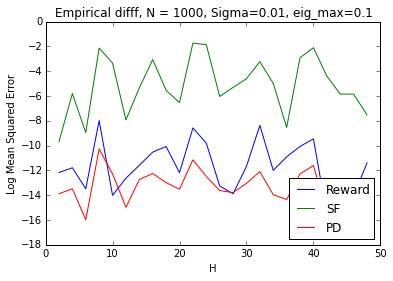

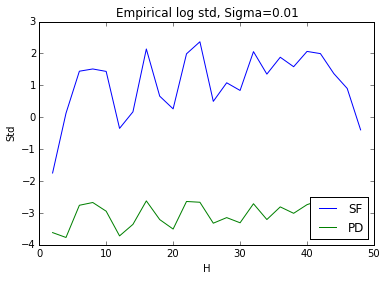

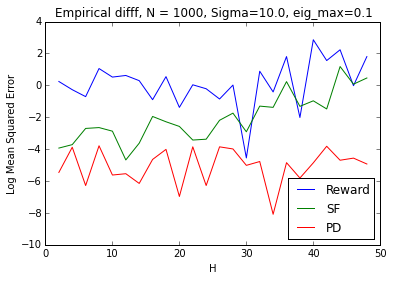

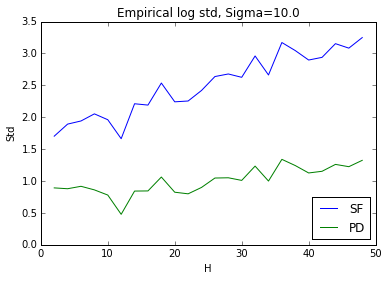

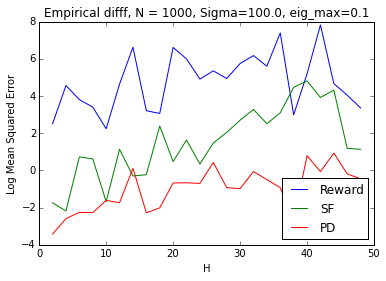

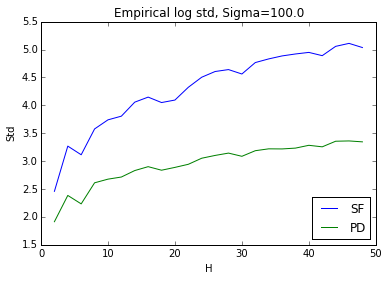

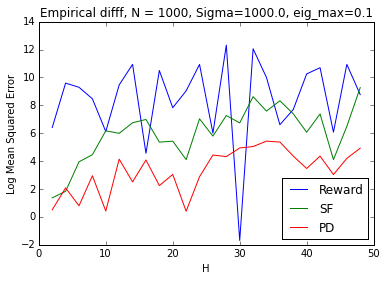

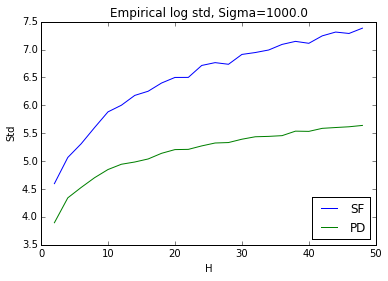

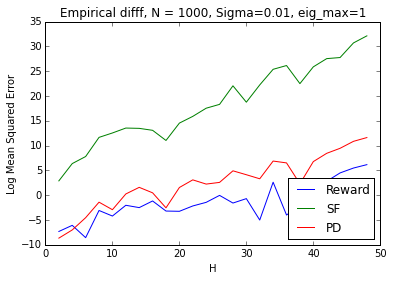

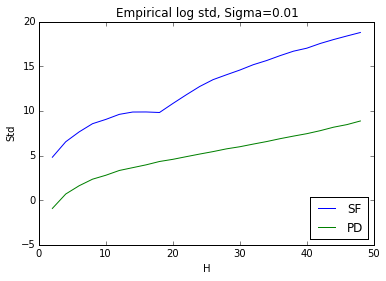

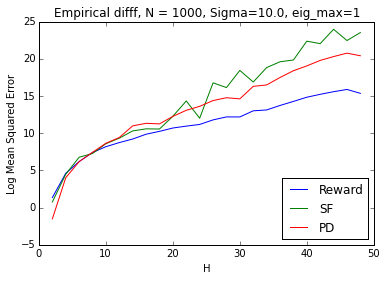

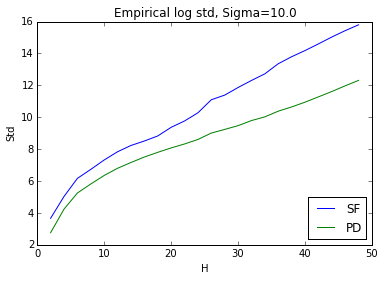

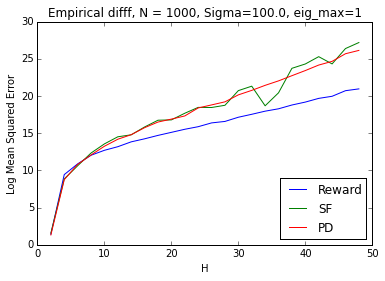

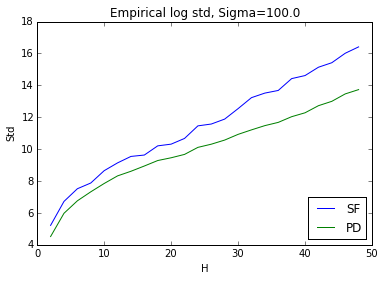

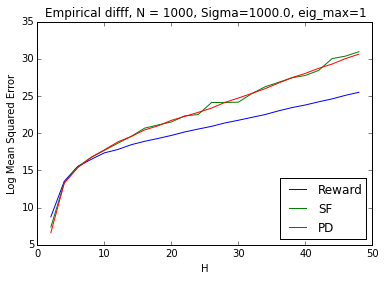

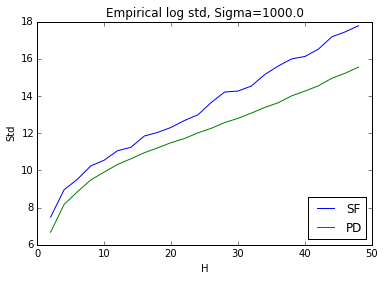

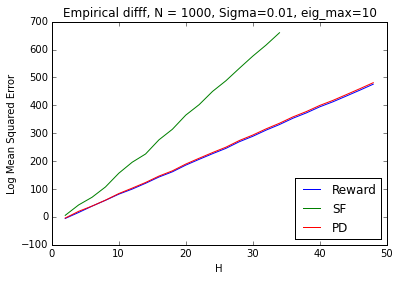

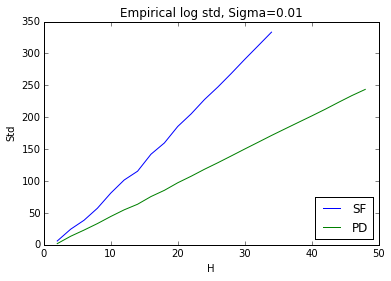

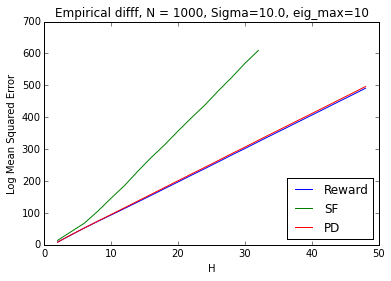

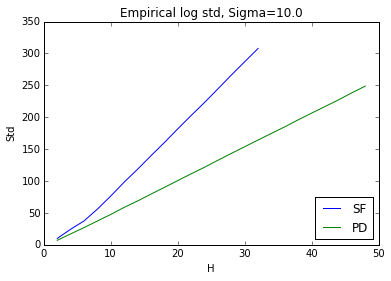

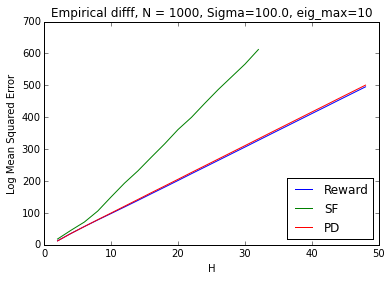

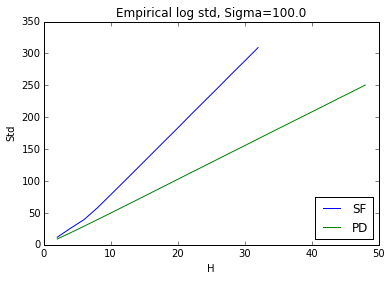

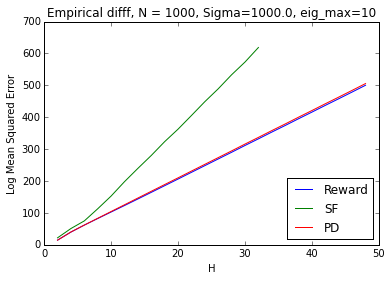

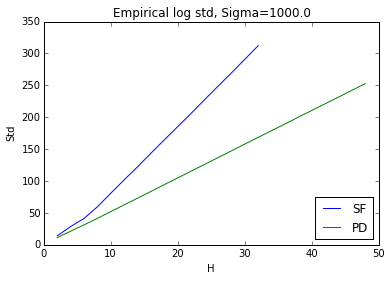

In [170]:
for state_dim in [4]:
    for action_dim in [2]:
        for max_eigen in [0.1, 1, 10]:
            A = init_matrix((state_dim, state_dim), max_eigen, 0.01) #np.random.randn(state_dim, state_dim)
            B = init_matrix((state_dim, action_dim), max_eigen, 0.01) #np.random.randn(state_dim, action_dim) * 100
            Q = init_matrix((state_dim, state_dim), 1, 0.01)
            R = init_matrix((action_dim, action_dim), 1, 0.01) 

            W = theano.shared(np.random.randn(action_dim, state_dim))
            b = theano.shared(np.random.randn(action_dim, 1))

            for name in ["A", "B", "Q", "R"]:
                def gen(name):
                    return lambda x: globals()[name]
                globals()["get_%s" % name] = gen(name)

            for ctrl_var in [1e-2, 1e1, 1e2, 1e3]:
                for H in range(2, 50, 2):
                    report()
                reward_diffs = []
                gradW_diff_sf = []
                gradW_sf_std = []
                gradW_diff_pd = []
                gradW_pd_std = []
                for H in range(2, 50, 2):
                    key = (state_dim, action_dim, ctrl_var, H, max_eigen)
                    dat = stats[key][0]
                    reward_diffs.append((np.square(dat[0] - dat[3][0])))
                    gradW_diff_sf.append(np.mean(np.square(dat[1] - dat[4][0])))
                    gradW_sf_std.append(np.mean(dat[4][1]))
                    gradW_diff_pd.append(np.mean(np.square(dat[1] - dat[5][0])))
                    gradW_pd_std.append(np.mean(dat[5][1]))
                plt.figure()
                ploty()

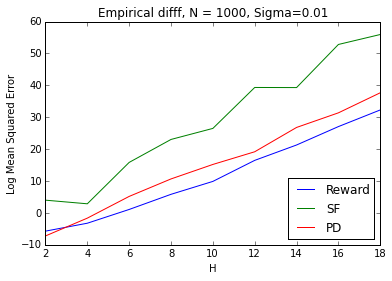

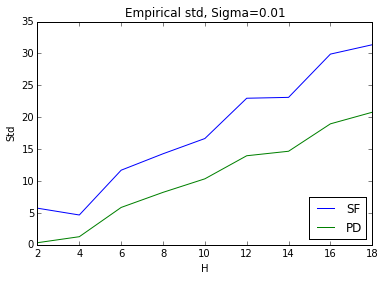

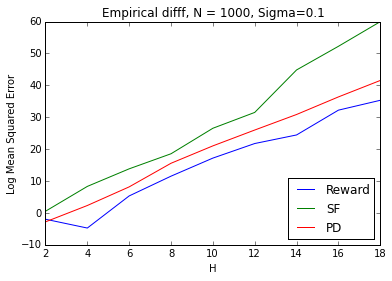

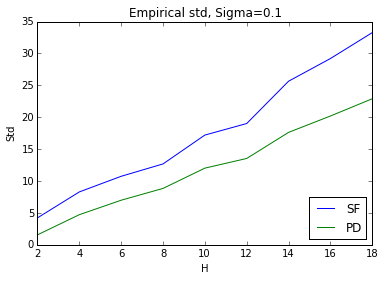

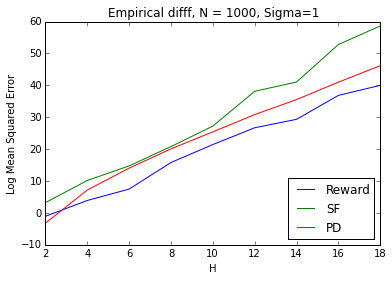

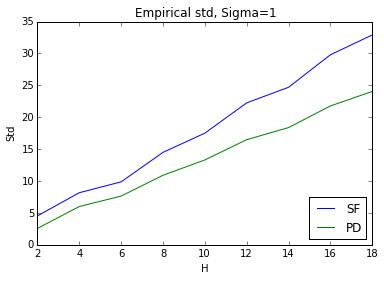

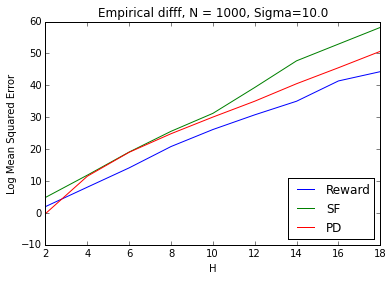

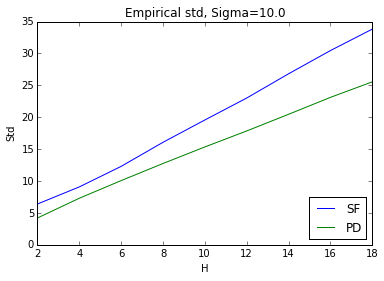

In [89]:
for ctrl_var in [1e-2, 1e-1, 1, 1e1]:
    reward_diffs = []
    gradW_diff_sf = []
    gradW_sf_std = []
    gradW_diff_pd = []
    gradW_pd_std = []
    for H in range(2, 20, 2):
        key = (state_dim, action_dim, ctrl_var, H)
        dat = stats[key][0]
        reward_diffs.append((np.square(dat[0] - dat[3][0])))
        gradW_diff_sf.append(np.mean(np.square(dat[1] - dat[4][0])))
        gradW_sf_std.append(np.mean(dat[4][1]))
        gradW_diff_pd.append(np.mean(np.square(dat[1] - dat[5][0])))
        gradW_pd_std.append(np.mean(dat[5][1]))
    plt.figure()
    ploty()

In [169]:
def ploty():
    xs = range(2, 50, 2)
    plt.plot(xs, np.log(reward_diffs), xs, np.log(gradW_diff_sf),xs, np.log(gradW_diff_pd),)
    plt.title("Empirical difff, N = 1000, Sigma=%s, eig_max=%s" % (ctrl_var, max_eigen))
    plt.legend(["Reward", "SF", "PD"], loc="lower right",)
    plt.xlabel("H")
    plt.ylabel("Log Mean Squared Error")
    plt.figure()
    plt.plot(xs, np.log(gradW_sf_std), xs, np.log(gradW_pd_std),)
    plt.title("Empirical log std, Sigma=%s" % ctrl_var)
    plt.legend(["SF", "PD"], loc="lower right",)
    plt.xlabel("H")
    plt.ylabel("Std")

In [154]:
key

(4, 2, 10.0, 18)

In [38]:
diffs

[array([  7.21562140e+00,   1.52702867e+05]),
 array([    3197.38771949,  3177324.54312056]),
 array([  1.37055662e+06,   1.50324420e+08]),
 array([  1.09857378e+09,   2.09974840e+10]),
 array([  2.27093900e+11,   1.84238311e+12]),
 array([  2.27902443e+13,   1.88988539e+14]),
 array([  1.63166634e+15,   3.24430539e+16]),
 array([  9.43394366e+17,   4.10291896e+18]),
 array([  1.73774194e+19,   6.59017255e+20])]

In [25]:
for state_dim in [2, 4, 8]:
    for action_dim in [1,2,3]:
        for ctrl_var in [1e-2, 1e-1, 1, 1e1]:
            key = (state_dim, action_dim, ctrl_var)
            d = stats[key]
            print key
            print d[0], d[3]
            print d[1], d[2]
            print d[4]
            print d[5]


(2, 1, 0.01)
-45398978.3465 (-28415360.720060639, 5240509.0305014644)
[[ -5.68769773e+08   6.18621943e+08]] [[-35459638.17207886]]
(array([[  4.20546119e+10,  -3.87396894e+10]]), array([[  2.15601796e+12,   1.98801064e+12]]))
(array([[ -4.59436733e+08,   4.17667767e+08]]), array([[ 79475233.10372943,  75392203.55462945]]))
(2, 1, 0.1)
-188186325.778 (-16873064.81310166, 12258681.33816264)
[[ -1.36710337e+09   2.26647945e+09]] [[-25910388.94449342]]
(array([[  6.03215122e+09,  -5.54428539e+09]]), array([[  4.81405198e+11,   4.43950256e+11]]))
(array([[ -2.51562714e+08,   2.35751514e+08]]), array([[  1.79012247e+08,   1.72321995e+08]]))
(2, 1, 1)
-1748720456.12 (-43974934.485152707, 55013164.445506021)
[[ -1.17078751e+10   2.08085201e+10]] [[-27412315.85531906]]
(array([[ -3.73742167e+10,   3.44396637e+10]]), array([[  1.34173164e+12,   1.23702629e+12]]))
(array([[ -6.75087272e+08,   6.19925926e+08]]), array([[  8.28254897e+08,   7.74750394e+08]]))
(2, 1, 10.0)
-17329419389.2 (-274526237

In [6]:
Sigma = np.identity(action_dim) * ctrl_var
control_noise = MultivariateGaussian(0, Sigma)


def linear_policy(x, noise=control_noise):
    return M.add(M.add(M.dot(W, x), b), noise)

def next_state(t, x_t, u_t):
    return M.add(
        M.dot(get_A(t), x_t),
        M.dot(get_B(t), u_t)
    )

def step_cost(t, x_t, u_t):
    Q = get_Q(t)
    R = get_R(t)
    static = x_t.mu.T.dot(Q).dot(x_t.mu) + u_t.mu.T.dot(R).dot(u_t.mu)
    var = TT.sum(Q * x_t.cov) + TT.sum(R * u_t.cov)
    return static + var


In [7]:
x0 = MultivariateGaussian(np.random.random((state_dim, 1)), 0)
H = 10
E_xs = [None for _ in xrange(H)]
E_xs[0] = x0
E_us = [None for _ in xrange(H)]
E_cs = [None for _ in xrange(H)]
for t in xrange(H):
    x_t = E_xs[t]
    u_t = linear_policy(x_t)
    x_tp = next_state(t, x_t, u_t)
    if t+1 < H:
        E_xs[t+1] = x_tp
    E_us[t] = u_t
    E_cs[t] = step_cost(t, x_t, u_t)

In [11]:
### print E_cs
s_cost = TT.sum(E_cs)
cost = s_cost.eval()
print cost
s_dW, s_db = TT.grad(s_cost, [W, b])
dW, db = s_dW.eval(), s_db.eval()
print dW, db

-49291116.2713
[[ -2.04561216e+06  -3.83064653e+07]
 [ -8.12323770e+07  -5.54325410e+08]] [[ -6731036.09553488]
 [-48204736.26256299]]


In [20]:
o = rollout(1000)
print o[0]
print o[1]
print o[3]

(-49667546.763590716, 10005621.222085783)
(array([[  4.78024911e+09,   2.00284429e+10],
       [ -5.68544702e+08,  -2.58499728e+09]]), array([[  2.19932643e+11,   9.29233001e+11],
       [  2.22890603e+11,   9.41896892e+11]]))
(array([[ -2.12681850e+06,  -3.85787887e+07],
       [ -8.20985701e+07,  -5.58583027e+08]]), array([[  9.27641990e+05,   7.18020211e+06],
       [  1.95136140e+07,   1.08096039e+08]]))


In [19]:
def det_linear_policy(x):
    return TT.dot(W, x) + b

def lognormpdf(x, mean, var):
    pi = np.pi
    denom = (2*pi*var)**.5
    lognum = (-(x-mean)**2/(2*var))
    return TT.sum(lognum - TT.log(denom))

def sym_grad_log_given(x, u):
    pi = linear_policy(x)
    import theano.tensor as OT
    return OT.grad(lognormpdf(u, pi.mu, TT.diag(pi.cov)[:, np.newaxis]), [W, b])

sx, su = TT.matrix("x"), TT.matrix("u")
grad_log_given = theano.function([sx, su], sym_grad_log_given(sx, su))

def gen_once():
    xs = [None for _ in xrange(H)]
    xs[0] = theano.shared(np.asarray(x0.mu))
    us = [None for _ in xrange(H)]
    cs = [None for _ in xrange(H)]
    random_noises = [TT.vector("w_%i" % i) for i in xrange(H)]
    for t in xrange(H):
        x_t = xs[t]
        u_t = det_linear_policy(x_t) + TT.dot(Sigma ** 0.5, random_noises[t])[:, np.newaxis]
        x_tp = TT.dot(get_A(t), x_t) + TT.dot(get_B(t), u_t)
        if t+1 < H:
            xs[t+1] = x_tp
        us[t] = u_t
        Q = get_Q(t)
        R = get_R(t)
        cs[t] = x_t.T.dot(Q).dot(x_t) + u_t.T.dot(R).dot(u_t)
    return theano.function(random_noises, xs+us+cs+TT.grad(TT.sum(cs), [W, b]))
     
once = gen_once()
def rollout(N = 100):
    sum_cs, sum_dWs, sum_dbs, sum_dWs_PD, sum_dbs_PD = [], [], [], [], []
    for _ in xrange(N):
        tracjectory = once(*[np.random.randn(action_dim).astype('float32') for _ in xrange(H)])
        xs, us, cs = [tracjectory[i*H:(i+1)*H] for i in xrange(3)]
        sum_dWs_PD.append(tracjectory[-2])
        sum_dbs_PD.append(tracjectory[-1])
        dWs = []
        dbs = []
        import theano.tensor as OT
        cum_cs = np.cumsum(cs[::-1])[::-1]
        for t in xrange(H-1, -1, -1):
            lW, lb = grad_log_given(xs[t].astype('float32'), us[t].astype('float32'))
            dWs.append(lW * cum_cs[t])
            dbs.append(lb * cum_cs[t])
        sum_cs.append(np.sum(cs))
        sum_dWs.append(np.sum(dWs, axis=0))
        sum_dbs.append(np.sum(dbs, axis=0))
    return [(np.mean(dat, axis=0), np.std(dat, axis=0)) for dat in [sum_cs, sum_dWs, sum_dbs, sum_dWs_PD, sum_dbs_PD]]

In [1116]:
# vals = []
def lognormpdf(x, mean, var):
    pi = np.pi
    denom = (2*pi*var)**.5
    lognum = (-(x-mean)**2/(2*var))
    return TT.sum(lognum - TT.log(denom))

def sym_grad_log_norm(x, mean, var, thetas):
#     vals += TT.grad((lognormpdf(x, mean, var)), thetas)
    
    return OT.grad((lognormpdf(x, mean, var)), mean, consider_constant=[x, var])

def grad_log_given(x, u):
    pi = linear_policy(x)
    import theano.tensor as OT
    return OT.grad(lognormpdf(u, pi.mu, TT.diag(pi.cov)), [W, b], consider_constant=[x.mu, x.cov, u])
#     return (u, pi.mu, TT.diag(pi.cov), [W, b])

def gen_once():
        E_xs = [None for _ in xrange(H)]
        E_xs[0] = MultivariateGaussian(theano.shared(np.asarray(x0.mu)), theano.shared(np.asarray(x0.cov)))
        E_us = [None for _ in xrange(H)]
        E_cs = [None for _ in xrange(H)]
        random_noises = [TT.vector("w_%i" % i) for i in xrange(H)]
        for t in xrange(H):
            x_t = E_xs[t]
            u_t = linear_policy(x_t, noise=TT.dot(Sigma, random_noises[t]))
#             vals.append(TT.grad(u_t.mu[0,0], W))
            x_tp = next_state(t, x_t, u_t)
            if t+1 < H:
                E_xs[t+1] = x_tp
            E_us[t] = u_t
            E_cs[t] = step_cost(t, x_t, u_t)
        total_cs = TT.sum(E_cs)
        cum_dWs = []
        cum_dbs = []
        import theano.tensor as OT
        cum_cs = OT.extra_ops.cumsum(E_cs[::-1])[::-1]
        for t in xrange(H-1, -1, -1):
            lW, lb = grad_log_given(E_xs[t], E_us[t].mu)
            cum_dWs.append(lW * cum_cs[t])
            cum_dbs.append(lb * cum_cs[t])
        return theano.function(random_noises, [total_cs, TT.sum(cum_dWs, axis=0), TT.sum(cum_dbs, axis=0)])
    
once = gen_once()
def rollout(N = 100):
    episodes = [once(*[np.random.randn(action_dim).astype('float32') for _ in xrange(H)]) for _ in xrange(N)]
    dats = [np.asarray([episode[i] for episode in episodes]) for i in xrange(3)]
    return [(np.mean(dat, axis=0), np.std(dat, axis=0)) for dat in dats]

In [801]:
once(*[np.random.randn(action_dim).astype('float32') for _ in xrange(H)])

[array(-8.553978820488997),
 array([[-6.70404711, -5.31270688]]),
 array([[-27.004418]])]

In [808]:
rollout()

[-9.0235113155160391, 0.89966334232151157, 3.7070941189953546]

In [324]:
once(*[np.random.randn(action_dim).astype('float32') for _ in xrange(H)])

[array(-15.907477617911576),
 array([[ 0.06692634,  2.10317118]]),
 array([[ 5.43417452]])]

In [57]:
def gen_once():
    E_xs = [None for _ in xrange(H)]
    E_xs[0] = MultivariateGaussian(theano.shared(np.asarray(x0.mu)), theano.shared(np.asarray(x0.cov)))
    E_us = [None for _ in xrange(H)]
    E_cs = [None for _ in xrange(H)]
    random_noises = [TT.vector("w_%i" % i) for i in xrange(H)]
    for t in xrange(H):
        x_t = E_xs[t]
        u_t = M.add(deterministic_linear_policy(x_t), TT.dot(Sigma, random_noises[t]))
        x_tp = next_state(t, x_t, u_t)
        if t+1 < H:
            E_xs[t+1] = x_tp
        E_us[t] = u_t
        E_cs[t] = step_cost(t, x_t, u_t)
#         print E_cs
    return theano.function(random_noises, map(lambda l: TT.stack(map(lambda x: x.mu if isinstance(x, M) else (x), l)), [E_xs, E_us, E_cs]))
once = gen_once()
xs, us, cs = once(*[np.random.randn(action_dim).astype('float32') for _ in xrange(H)])
cum_dW = 0.
cum_db = 0.
cum_c = cs[-1]
for t in xrange(H-2, -1, -1):
    lW, lb = grad_log_given(xs[t], us[t])
    cum_dW += lW * cum_c
    cum_db += lb * cum_c
    cum_c += cs[t]


In [59]:
cum_dW.eval()


array([[  1.98006328e+11,   3.72782461e+11]])

In [173]:
a = np.asarray([[0,1], [1,0]])
np.linalg.svd(a)

(array([[ 0., -1.],
        [-1.,  0.]]), array([ 1.,  1.]), array([[-1., -0.],
        [-0., -1.]]))